In [51]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb ## XGBoost 불러오기
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss, recall_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.metrics import f1_score, roc_auc_score, log_loss
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from xgboost import plot_importance ## Feature Importance를 불러오기 위함
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [53]:
import os
os.chdir('../open')

In [54]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [4]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,occyp_type_Laborers,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,0,0,0,1,0,0,0
1,7,M,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
2,12,F,Y,Y,1,157500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
3,15,M,Y,Y,2,157500.0,Working,Secondary / secondary special,Married,With parents,...,0,0,0,0,0,0,0,0,0,0
4,22,F,N,N,0,157500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,...,1,0,0,0,0,0,0,0,0,0


In [5]:
test.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,occyp_type_Laborers,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,...,0,0,0,0,0,0,0,0,0,0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,0,0,0,0,0,0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,...,0,0,1,0,0,0,0,0,0,0


In [6]:
train.shape

(9660, 65)

In [7]:
test.shape

(10000, 64)

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9660 entries, 0 to 9659
Data columns (total 65 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   index                                   9660 non-null   int64  
 1   gender                                  9660 non-null   object 
 2   car                                     9660 non-null   object 
 3   reality                                 9660 non-null   object 
 4   child_num                               9660 non-null   int64  
 5   income_total                            9660 non-null   float64
 6   income_type                             9660 non-null   object 
 7   edu_type                                9660 non-null   object 
 8   family_type                             9660 non-null   object 
 9   house_type                              9660 non-null   object 
 10  DAYS_BIRTH                              9660 non-null   int6

# 데이터 전처리

In [9]:
train.isnull().sum()

index                              0
gender                             0
car                                0
reality                            0
child_num                          0
                                  ..
occyp_type_Realty agents           0
occyp_type_Sales staff             0
occyp_type_Secretaries             0
occyp_type_Security staff          0
occyp_type_Waiters/barmen staff    0
Length: 65, dtype: int64

In [10]:
print(train['income_type'].unique())
print(train['edu_type'].unique())
print(train['family_type'].unique())
print(train['house_type'].unique())

['Commercial associate' 'Working' 'Pensioner' 'State servant' 'Student']
['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
['Married' 'Civil marriage' 'Separated' 'Single / not married' 'Widow']
['House / apartment' 'With parents' 'Co-op apartment' 'Rented apartment'
 'Municipal apartment' 'Office apartment']


<AxesSubplot:>

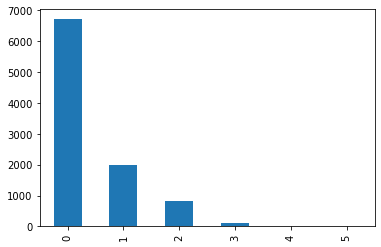

In [11]:
train['child_num'].value_counts(sort=False).plot.bar()

In [12]:
print(train['income_total'].value_counts(bins=10,sort=False))

(25451.999, 181800.0]     5960
(181800.0, 336600.0]      2999
(336600.0, 491400.0]       563
(491400.0, 646200.0]        85
(646200.0, 801000.0]        37
(801000.0, 955800.0]        13
(955800.0, 1110600.0]        2
(1110600.0, 1265400.0]       0
(1265400.0, 1420200.0]       0
(1420200.0, 1575000.0]       1
Name: income_total, dtype: int64


<AxesSubplot:ylabel='Frequency'>

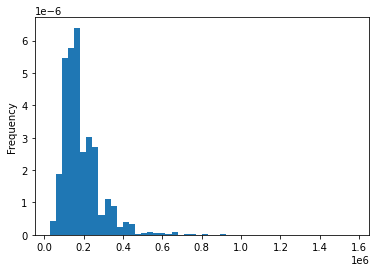

In [13]:
train['income_total'].plot(kind='hist',bins=50,density=True)

In [14]:
train

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,occyp_type_Laborers,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,0,0,0,1,0,0,0
1,7,M,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
2,12,F,Y,Y,1,157500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
3,15,M,Y,Y,2,157500.0,Working,Secondary / secondary special,Married,With parents,...,0,0,0,0,0,0,0,0,0,0
4,22,F,N,N,0,157500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9655,4972,F,Y,Y,1,133650.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
9656,4973,F,N,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,1,0,0,0,0,0,0
9657,4975,F,N,Y,1,135000.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,0,0,0,0,0,0
9658,4976,F,N,Y,2,112500.0,Working,Secondary / secondary special,Married,With parents,...,0,0,0,0,0,0,0,0,0,0


In [15]:
test

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,occyp_type_Laborers,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff
0,26457,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,...,0,0,0,0,0,0,0,0,0,0
1,26458,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
2,26459,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,...,1,0,0,0,0,0,0,0,0,0
3,26460,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
4,26461,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,36452,F,Y,Y,0,202500.0,Working,Incomplete higher,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0
9996,36453,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,...,1,0,0,0,0,0,0,0,0,0
9997,36454,F,N,Y,0,292500.0,Working,Secondary / secondary special,Married,House / apartment,...,0,0,0,1,0,0,0,0,0,0
9998,36455,F,Y,N,0,180000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,0,0,0,0,0,0,0,0,0,0


In [16]:
train.shape

(9660, 65)

In [17]:
test.shape

(10000, 64)

# 데이터 모델링

In [18]:
train_x=train.drop('credit', axis=1)
train_y=train[['credit']]
test_x=test

In [19]:
train_x=train_x.drop(['gender', 'car', 'reality', 'income_type',
                'edu_type', 'family_type', 'house_type', 'occyp_type'], axis=1)
test_x=test_x.drop(['gender', 'car', 'reality', 'income_type',
                'edu_type', 'family_type', 'house_type', 'occyp_type'], axis=1)

In [20]:
print(train_x.shape, train_y.shape, test_x.shape)

(9660, 56) (9660, 1) (10000, 56)


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.metrics import f1_score
from tensorflow.keras.utils import to_categorical

X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.2,
                                                    random_state = 9660)

print("Train set: ")
print(X_train.shape)
print(y_train.shape)
print("===========")
print("Test set: ")
print(X_test.shape)
print(y_test.shape)


clf=XGBClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict_proba(X_test)

print(f"log_loss: {log_loss(to_categorical(y_test['credit']), y_pred)}")

Train set: 
(7728, 56)
(7728, 1)
Test set: 
(1932, 56)
(1932, 1)
[20:27:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
log_loss: 0.5985595223628282


In [22]:
clf = XGBClassifier(n_estimator=500, learning_rate=0.1, max_depth=4)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

[20:27:02] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[20:27:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [24]:
accuracy_score(y_test, pred)

0.7468944099378882

In [27]:
clf = XGBClassifier()
clf_param_grid = {
    'n_estimators' : [100, 200, 400, 600],
    'learning_rate' : [0.01, 0.05, 0.1, 0.15, 0.2],
    'max_depth' : [4, 6, 8, 10, 12],
}

clf_grid = GridSearchCV(clf, param_grid = clf_param_grid, scoring="accuracy", n_jobs=-1, verbose=1)
clf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[21:25:44] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameter

In [28]:
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dval = xgb.DMatrix(data=X_test, label=y_test)
dtest = xgb.DMatrix(data=test_x)

In [29]:
# max_depth = 3, 학습률은 0.1, 예제가 이진분류이므로 목적함수(objective)는 binary:logistic(이진 로지스틱)
# 오류함수의 평가성능지표는 logloss
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 4,
         'eta' : 0.2,
         'eval_metric' : 'mlogloss',
         'objective' : 'multi:softprob',
         'num_class' : 3,
         'early_stoppings' : 100 }

num_rounds = 400

In [31]:
def run_xgboost(clf):

    outcomes=[]
    sub=np.zeros((test_x.shape[0], 3))
    
    # train 데이터 세트는 'train', evaluation 데이터 세트는 'eval' 로 명시
    wlist = [(dtrain, 'train'), (dval,'eval')]
    
    # 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
    xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)
    
    predictions = np.round(xgb_model.predict(dval), 3)

    logloss=log_loss(to_categorical(y_test['credit']), predictions)
    outcomes.append(logloss)
    min_outcome=np.min(outcomes)
    
    sub = np.round(xgb_model.predict(dtest), 3)
    
    print("Min:{}".format(min_outcome))

    return sub

my_submission = run_xgboost(clf)

[21:28:36] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stoppings } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-mlogloss:0.97979	eval-mlogloss:0.97649
[1]	train-mlogloss:0.89635	eval-mlogloss:0.89067
[2]	train-mlogloss:0.83537	eval-mlogloss:0.82763
[3]	train-mlogloss:0.78958	eval-mlogloss:0.78023
[4]	train-mlogloss:0.75464	eval-mlogloss:0.74447
[5]	train-mlogloss:0.72762	eval-mlogloss:0.71663
[6]	train-mlogloss:0.70573	eval-mlogloss:0.69581
[7]	train-mlogloss:0.68865	eval-mlogloss:0.67849
[8]	train-mlogloss:0.67504	eval-mlogloss:0.66484
[9]	train-mlogloss:0.66402	eval-mlogloss:0.65385
[10]	train-mlogloss:0.65485	eval-mlogloss:0.64481
[11]	train-mlogloss:0.64733	eval-mlogloss:0.63778
[12]	train-mlogloss:0.64094	eval-mlogloss:0.63190
[13]	train-mlogloss:0.635

[157]	train-mlogloss:0.45098	eval-mlogloss:0.58680
[158]	train-mlogloss:0.45054	eval-mlogloss:0.58666
[159]	train-mlogloss:0.44973	eval-mlogloss:0.58665
[160]	train-mlogloss:0.44907	eval-mlogloss:0.58666
[161]	train-mlogloss:0.44813	eval-mlogloss:0.58670
[162]	train-mlogloss:0.44772	eval-mlogloss:0.58702
[163]	train-mlogloss:0.44710	eval-mlogloss:0.58704
[164]	train-mlogloss:0.44605	eval-mlogloss:0.58699
[165]	train-mlogloss:0.44547	eval-mlogloss:0.58709
[166]	train-mlogloss:0.44422	eval-mlogloss:0.58716
[167]	train-mlogloss:0.44315	eval-mlogloss:0.58680
[168]	train-mlogloss:0.44205	eval-mlogloss:0.58658
[169]	train-mlogloss:0.44154	eval-mlogloss:0.58723
[170]	train-mlogloss:0.44058	eval-mlogloss:0.58727
[171]	train-mlogloss:0.44018	eval-mlogloss:0.58732
[172]	train-mlogloss:0.43977	eval-mlogloss:0.58739
[173]	train-mlogloss:0.43887	eval-mlogloss:0.58788
[174]	train-mlogloss:0.43813	eval-mlogloss:0.58773
[175]	train-mlogloss:0.43743	eval-mlogloss:0.58806
[176]	train-mlogloss:0.43670	ev

[318]	train-mlogloss:0.33415	eval-mlogloss:0.59232
[319]	train-mlogloss:0.33357	eval-mlogloss:0.59187
[320]	train-mlogloss:0.33326	eval-mlogloss:0.59193
[321]	train-mlogloss:0.33274	eval-mlogloss:0.59210
[322]	train-mlogloss:0.33212	eval-mlogloss:0.59196
[323]	train-mlogloss:0.33177	eval-mlogloss:0.59223
[324]	train-mlogloss:0.33113	eval-mlogloss:0.59228
[325]	train-mlogloss:0.33098	eval-mlogloss:0.59255
[326]	train-mlogloss:0.33014	eval-mlogloss:0.59266
[327]	train-mlogloss:0.32932	eval-mlogloss:0.59249
[328]	train-mlogloss:0.32869	eval-mlogloss:0.59243
[329]	train-mlogloss:0.32834	eval-mlogloss:0.59269
[330]	train-mlogloss:0.32781	eval-mlogloss:0.59295
[331]	train-mlogloss:0.32711	eval-mlogloss:0.59283
[332]	train-mlogloss:0.32655	eval-mlogloss:0.59291
[333]	train-mlogloss:0.32613	eval-mlogloss:0.59314
[334]	train-mlogloss:0.32578	eval-mlogloss:0.59294
[335]	train-mlogloss:0.32520	eval-mlogloss:0.59312
[336]	train-mlogloss:0.32435	eval-mlogloss:0.59333
[337]	train-mlogloss:0.32377	ev

In [33]:
my_submission

array([[1.   , 0.   , 0.   ],
       [0.999, 0.001, 0.   ],
       [1.   , 0.   , 0.   ],
       ...,
       [1.   , 0.   , 0.   ],
       [1.   , 0.   , 0.   ],
       [0.997, 0.003, 0.   ]], dtype=float32)

In [55]:
submission

,index,0,1,2
0,26457,0,0,0
1,26458,0,0,0
2,26459,0,0,0
3,26460,0,0,0
4,26461,0,0,0
...,...,...,...,...
9995,36452,0,0,0
9996,36453,0,0,0
9997,36454,0,0,0
9998,36455,0,0,0


In [57]:
submission.loc[:,1:]=my_submission

In [58]:
submission

,index,0,1,2
0,26457,1.000,0.000,0.0
1,26458,0.999,0.001,0.0
2,26459,1.000,0.000,0.0
3,26460,1.000,0.000,0.0
4,26461,1.000,0.000,0.0
...,...,...,...,...
9995,36452,1.000,0.000,0.0
9996,36453,1.000,0.000,0.0
9997,36454,1.000,0.000,0.0
9998,36455,1.000,0.000,0.0
